Term Frequency Method 

##### for predictions = 1000 , F1 Score : 23.69 



In [2]:
from os import listdir
import pandas as pd
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk import pos_tag
import re
import string
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

In [3]:
FINAL_CORPUS = './data/corpus/corpus_cleaned.pkl'
corpus = pd.read_pickle(FINAL_CORPUS)
corpus.sample(3)

,article,summary,article_char_count,article_word_count,article_sentence_count,summary_char_count,summary_word_count,summary_sentence_count
13606,Jesse Altman makes himself at home when he tra...,Atlanta man stays with friends while on busine...,6241,1096,61,313,47,4
20485,"On July 1, 2013 the 27-nation European Union w...",Croatia will be only the second ex-Yugoslav co...,5252,848,46,269,42,3
55270,"Watch or record ""Black in America: The New Pro...","""The New Promised Land"" follows the progress o...",6849,1072,83,332,44,2


In [4]:
PUNCTUATION_STOP = ['"', "'", '.', '...', '!', '?', '(', ')', '[', ']', '{', '}', '\\', '/', ':', ',', '...',
               '$', '#', '%', '*', '%', '$', '#', '@', '--', '-', '_', '+', '=', '^', "''", '""', '','those', 'on', 'own', '’ve', 'yourselves', 'around', 'between', 'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', '‘ll', 'doing', 'everything', 'up', 'onto', 'never', 'either', 'how', 'before', 'anyway', 'since', 'through', 'amount', 'now', 'he', 'was', 'have', 'into', 'because', 'not', 'therefore', 'they', 'n’t', 'even', 'whom', 'it', 'see', 'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 'whenever', 'seem', 'until', 'whereby', 'at', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'once', 'will', 'noone', "'m", 'that', 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'which', 'would', 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'ourselves', 'few', 'did', 'without', 'third', 'anything', 'twelve', 'against', 'while', 'twenty', 'if', 'however', 'herself', 'when', 'may', 'ours', 'six', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'where', 'otherwise', 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'others', 'show', '’s', 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'could', 'five', 'unless', 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'n‘t', 'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about', 'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 'beforehand', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from', 'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across', '‘s', '’re', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after', 'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed', 'most', 'everywhere', 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'side', 'former', 'anyone', 'full', 'has', 'yours', 'whose', 'behind', 'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 'per', 'eleven', 'ever', '‘re', 'enough', "n't", 'again', '‘d', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 'everyone', 'towards', 'this', 'cannot', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', '‘ve']


In [5]:

# Remove  punctuation/stopwords
def tokens_without_punctuation(text):
    tokens = word_tokenize(text)

    no_punctuation=[]
    for x in tokens:
        if x not in PUNCTUATION_STOP:
            no_punctuation.append(x)
    return no_punctuation

# Separates text into sentences
def  sentence_tokenize(text):
     sentence_tokenized = list()
     for txt in text.split('\n'):
          sentence_tokenized += sent_tokenize(txt)
     return sentence_tokenized

# words_list: list of words to be tokenized
# tokenizer: (string) can be 'lemma' or 'stem'
def _create_list_of_tokens(words_list, tokenizer):

     if tokenizer == 'lemma':
          token_maker = lambda word: WordNetLemmatizer().lemmatize(word).lower()
     else:
          token_maker = lambda word: PorterStemmer().stem(word).lower()
     token_list = list()

     for word in words_list:
          token = token_maker(word)
          if token not in PUNCTUATION_STOP:
               token_list.append(token)
     return token_list

 
# token_list: list of tokens
# n_gram:  (string) the highest n-gram => '1-gram', '2-gram', '3-gram'
# return: list of all ranges from the unigrams to n-grams
def _create_list_of_ngrams(token_list, n_gram):
    
     n_gram_list = []
     n = int(n_gram[0])
     for i in range(1, n + 1):
          i_grams = ngrams(token_list, i)
          n_gram_list += [' '.join(grams) for grams in i_grams]
     return n_gram_list

def _create_dictionary_table(text, tokenizer = 'stem', n_gram = '1-gram'):
  
    # Words tokenized => Not Stem/Leema Yet
    words_list = tokens_without_punctuation(text)

    # Tokens stemmed/lemmitized
    token_list = _create_list_of_tokens(words_list, tokenizer)

    # list of n-grams 
    n_gram_list = _create_list_of_ngrams(token_list, n_gram)

    # dictionary to count the frequency of n-grams
    frequency_table = dict()

    for n_gram_item in n_gram_list:  
          if n_gram_item in frequency_table:
              frequency_table[n_gram_item] += 1
          else:
              frequency_table[n_gram_item] = 1
    
    return frequency_table

def _weighted_freq_table(ft):
     keyName=max(zip(ft.values(), ft.keys()))[1]
     keyValue=int(max(zip(ft.values(), ft.keys()))[0])

     ft = {key: value / keyValue for key, value in ft.items()}
     return ft

In [6]:

def _calculate_sentence_scores(sentences, frequency_table, tokenizer = 'stem', n_gram = '1-gram') -> dict:   

    sentence_weight = dict()
    for sentence in sentences:
        words_list = tokens_without_punctuation(sentence)
        token_list = _create_list_of_tokens(words_list, tokenizer)
        n_gram_list = _create_list_of_ngrams(token_list, n_gram)

        sentence_count = 0
        
        for n_gram_item in n_gram_list:
            
            if n_gram_item in frequency_table:
                sentence_count += 1

                if sentence in sentence_weight:
                    sentence_weight[sentence] += frequency_table[n_gram_item]
                else:
                    sentence_weight[sentence] = frequency_table[n_gram_item]
                    
        if sentence in sentence_weight and sentence_weight[sentence] > 0:
          sentence_weight[sentence] = sentence_weight[sentence] / sentence_count
        else:
          sentence_weight[sentence] = 0
    return sentence_weight
  
 
# Average score for the sentences
def _calculate_average_score(sentence_weight) -> int:
   
    sum_values = 0
    for entry in sentence_weight:
        sum_values += sentence_weight[entry]

    # print("Sum of Sentence Scores : ",sum_values , " No of Sentences: ", len(sentence_weight))
    average_score = (sum_values / len(sentence_weight))
    
    return average_score


def _get_article_summary(sentences, sentence_weight, threshold):
    sentence_counter = 0
    article_summary = ''

    for sentence in sentences:
        if sentence in sentence_weight and sentence_weight[sentence] >= (threshold):
            article_summary += " " + sentence
            sentence_counter += 1
    return article_summary


def run_article_summary(article, tokenizer = 'stem', n_gram = '1-gram', threshold_factor = 1):
    
    frequency_table = _create_dictionary_table(article, tokenizer, n_gram)

    sentences = sentence_tokenize(article)

    sentence_scores = _calculate_sentence_scores(sentences, frequency_table, tokenizer, n_gram)

    average_score = _calculate_average_score(sentence_scores)

    article_summary = _get_article_summary(sentences, sentence_scores, (threshold_factor*average_score))

    return article_summary



In [7]:
article1="Ram is a good boy. Ram is 18 years old. He likes playing football and basketball. He is very good in both. Among all the boys of his class,he is best in playing football."
run_article_summary(article1,threshold_factor=0.9)

' Ram is a good boy. He is very good in both. Among all the boys of his class,he is best in playing football.'

In [8]:
article2="Rama is the titular protagonist and the first son of King Dasaratha. Though in this story Rama is a human, he's actually an avatar of the god Vishnu, who decided to take a human form in order to kill the evil rakshasa (demon) Ravana. Because of this, Rama's true identity is identifiable by his desire to rid the world of evil. He's exceptionally strong and skilled in battle, which is also an early clue to those around him that he's an incarnation of Vishnu. Rama uses this strength to string Shiva's bow and win Sita's hand in marriage. Though every citizen of Kosala wants Rama to be king, Rama demonstrates his intense loyalty and honor when he insists that Dasaratha uphold his promise to Kaikeyi, one of his wives, and crown Rama's brother, Bharatha, king instead. Rama retreats to the forests with Sita and his brother, Lakshmana, for 14 years, during which time Rama battles demons and rakshasas. When Ravana kidnaps Sita, Rama works closely with the monkeys of Kiskinda to rescue her. During the fight with Ravana, Rama behaves honorably by allowing Ravana time to recover from fainting spells, and even doubts the legitimacy and righteousness of his victory when he notices an injury on Ravana's back and fears that he inflicted it while Ravana fled. Though Rama has a streak of jealousy and possessiveness, especially when it comes to Sita (and even moreso in a later episode that is left out of this version of the epic), in general he is presented as the ideal hero and man."
run_article_summary(article2,"lemma")

" Rama is the titular protagonist and the first son of King Dasaratha. Rama uses this strength to string Shiva's bow and win Sita's hand in marriage. Though every citizen of Kosala wants Rama to be king, Rama demonstrates his intense loyalty and honor when he insists that Dasaratha uphold his promise to Kaikeyi, one of his wives, and crown Rama's brother, Bharatha, king instead. Rama retreats to the forests with Sita and his brother, Lakshmana, for 14 years, during which time Rama battles demons and rakshasas. When Ravana kidnaps Sita, Rama works closely with the monkeys of Kiskinda to rescue her."

In [9]:
def nice_print(article, reference_summary, hypothesis_summary, width  = 300):
  dedented_text = lambda text: textwrap.dedent(text).strip()
  if article:
    print('ARTICLE')
    print(textwrap.fill(dedented_text(article), width=width), '\n')
  if reference_summary:
    print('REFERENCE SUMMARY: Summary from Dataset')
    print(textwrap.fill(dedented_text(reference_summary), width=width), '\n')
  if hypothesis_summary:
    print('HYPOTHESIS SUMMARY : Summary generated from Algorithm')
    print(textwrap.fill(dedented_text(hypothesis_summary), width=width), '\n')

In [52]:
idx = corpus.sample(1).index[0]
print(idx)
article = corpus.loc[idx, 'article']
reference_summary = corpus.loc[idx, 'summary']
hypothesis_summary = run_article_summary(article, 
                                         tokenizer = 'stem', 
                                         n_gram = '1-gram', 
                                         threshold_factor = 1.2)
# nice_print(article, reference_summary, hypothesis_summary)


import rouge

evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = 1,
                           limit_length = True,
                           length_limit = 100,
                           length_limit_type = 'words',
                           alpha = 0.5, # Default F1_score
                           stemming=True)

hypothesis = hypothesis_summary
reference = reference_summary

scores = evaluator.get_scores(hypothesis, reference)
print(scores) 

# 54367

87026
{'rouge-1': {'f': 0.28148148148148144, 'p': 0.19, 'r': 0.5428571428571428}}


In [54]:
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, # Default F1_score
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)]

      return rouge_score

In [58]:
import rouge
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha,
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)]

      return rouge_score

idxs=[12168,34861,87066,13950,40082,84878,87026]
for idx in idxs:
    article = corpus.loc[idx, 'article']
    reference_summary = corpus.loc[idx, 'summary']
    hypothesis_summary = run_article_summary(article, 
                                         tokenizer = 'stem', 
                                         n_gram = '1-gram', 
                                         threshold_factor = 1.2)
    print(rouge_scoring(hypothesis_summary,reference_summary))

{'f': 0.25210084033613445, 'p': 0.15463917525773196, 'r': 0.6818181818181818}
{'f': 0.43333333333333335, 'p': 0.3132530120481928, 'r': 0.7027027027027027}
{'f': 0.42000000000000004, 'p': 0.44680851063829785, 'r': 0.39622641509433965}
{'f': 0.5142857142857142, 'p': 1.0, 'r': 0.34615384615384615}
{'f': 0.24390243902439027, 'p': 0.14893617021276595, 'r': 0.6730769230769231}
{'f': 0.25641025641025644, 'p': 0.16393442622950818, 'r': 0.5882352941176471}
{'f': 0.22222222222222224, 'p': 0.1306532663316583, 'r': 0.7428571428571429}


Predictions

In [11]:
def run_on_corpus(df, n_gram_list, token_type_list, threshold_factor_list,n_predictions):


  t0 = time.time()

  sampling_interval = len(df) // n_predictions
  index = df.index[::sampling_interval][:n_predictions]
  data = df.loc[index, 'summary']
  predictions = pd.DataFrame( data = data.values , columns = ['reference'], index = index)

  for n_gram in n_gram_list:
    for token_type in token_type_list:
      for threshold_factor in threshold_factor_list:
        predicted_column = n_gram + '_' + token_type + '_' + str(threshold_factor)
        print('Prediction colum: {}'.format(predicted_column))

        predictions.loc[index, predicted_column] = df.loc[index, 'article'].apply(run_article_summary,
                                                                            args =(token_type, 
                                                                                   n_gram, 
                                                                                   threshold_factor))
        
        print('Time taken {:.2f} minutes'.format((time.time() - t0)/60))
          
    
  print()
  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return predictions

In [12]:
n_gram_list = ['1-gram', '2-gram', '3-gram']
token_type_list = ['stem', 'lemma']
threshold_factor_list = [1, 1.1, 1.2, 1.3, 1.4]
n_predictions = 1000
predictions_test = run_on_corpus(corpus, n_gram_list, token_type_list, threshold_factor_list,n_predictions)

predictions_test.to_pickle('./data/corpus/predictions_freq_score_1000.pkl')

Prediction colum: 1-gram_stem_1
Time taken 0.75 minutes
Prediction colum: 1-gram_stem_1.1
Time taken 1.50 minutes
Prediction colum: 1-gram_stem_1.2
Time taken 2.19 minutes
Prediction colum: 1-gram_stem_1.3
Time taken 2.89 minutes
Prediction colum: 1-gram_stem_1.4
Time taken 3.58 minutes
Prediction colum: 1-gram_lemma_1
Time taken 3.95 minutes
Prediction colum: 1-gram_lemma_1.1
Time taken 4.31 minutes
Prediction colum: 1-gram_lemma_1.2
Time taken 4.68 minutes
Prediction colum: 1-gram_lemma_1.3
Time taken 5.06 minutes
Prediction colum: 1-gram_lemma_1.4
Time taken 5.43 minutes
Prediction colum: 2-gram_stem_1
Time taken 6.13 minutes
Prediction colum: 2-gram_stem_1.1
Time taken 6.83 minutes
Prediction colum: 2-gram_stem_1.2
Time taken 7.53 minutes
Prediction colum: 2-gram_stem_1.3
Time taken 8.23 minutes
Prediction colum: 2-gram_stem_1.4
Time taken 8.94 minutes
Prediction colum: 2-gram_lemma_1
Time taken 9.31 minutes
Prediction colum: 2-gram_lemma_1.1
Time taken 9.69 minutes
Prediction colu

In [13]:
predictions_test=pd.read_pickle('./data/corpus/predictions_freq_score_1000.pkl')
predictions_test.sample(5)

,reference,1-gram_stem_1,1-gram_stem_1.1,1-gram_stem_1.2,1-gram_stem_1.3,1-gram_stem_1.4,1-gram_lemma_1,1-gram_lemma_1.1,1-gram_lemma_1.2,1-gram_lemma_1.3,...,3-gram_stem_1,3-gram_stem_1.1,3-gram_stem_1.2,3-gram_stem_1.3,3-gram_stem_1.4,3-gram_lemma_1,3-gram_lemma_1.1,3-gram_lemma_1.2,3-gram_lemma_1.3,3-gram_lemma_1.4
54604,Amory Lovins says smart businesses are becomin...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...,Amory Lovins founded the Rocky Mountain Insti...
59507,Bowe Bergdahl is now in outpatient care.\r\nHi...,"Army Sgt. Bowe Bergdahl, released from Taliba...","Army Sgt. Bowe Bergdahl, released from Taliba...","Army Sgt. Bowe Bergdahl, released from Taliba...",Army Sgt.,Army Sgt.,"Army Sgt. Bowe Bergdahl, released from Taliba...","Army Sgt. Bowe Bergdahl, released from Taliba...",Army Sgt. He is the seventh person to go thro...,Army Sgt.,...,"Army Sgt. Bowe Bergdahl, released from Taliba...","Army Sgt. Bowe Bergdahl, released from Taliba...",Army Sgt. The program began at Brooke Army Me...,Army Sgt.,Army Sgt.,"Army Sgt. Bowe Bergdahl, released from Taliba...","Army Sgt. Bowe Bergdahl, released from Taliba...",Army Sgt. The program began at Brooke Army Me...,Army Sgt.,Army Sgt.
70379,David Kusnet: Barack Obama's Syria speech chan...,"Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...",...,"Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Read the speech In only 15 minutes, President...","Read the speech In only 15 minutes, President...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Sixty-one percent of Americans polled, who wa...","Read the speech In only 15 minutes, President...","Read the speech In only 15 minutes, President..."
84436,Gomez and Bieber quietly adopted a dog.\r\nGom...,"Winnipeg animal rescue D'Arcy's A.R.C. ""They ...","Winnipeg animal rescue D'Arcy's A.R.C. ""They ...","Winnipeg animal rescue D'Arcy's A.R.C. ""I was...","Winnipeg animal rescue D'Arcy's A.R.C. ""I was...",,"Winnipeg animal rescue D'Arcy's A.R.C. ""They ...","Winnipeg animal rescue D'Arcy's A.R.C. ""They ...","Winnipeg animal rescue D'Arcy's A.R.C. ""I was...","""I was told that [Gomez] was missing the dogs...",...,"Winnipeg animal rescue D'Arcy's A.R.C. ""They ...","Winnipeg animal rescue D'Arcy's A.R.C. ""I was...","Winnipeg animal rescue D'Arcy's A.R.C. ""I was...",,,"Winnipeg animal rescue D'Arcy's A.R.C. ""They ...","Winnipeg animal rescue D'Arcy's A.R.C. ""I was...","Winnipeg animal rescue D'Arcy's A.R.C. ""I was...",,
23400,Solange Knowles married in New Orleans on Sund...,Solange Knowles has always been independent. ...,Solange Knowles has always

In [14]:
len(predictions_test)

1000

In [53]:
# Rouge Score between hypothesis and reference summaries
def rouge_scoring(hypothesis, reference, max_n = 1, alpha = 0.5, score = 'F1'):
      
      evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, 
                           stemming = True)
      if score == 'F1':
          score_entry = 'f'
      elif score == 'Precision':
          score_entry = 'p'
      else:
          score == 'Recall'
          score_entry = 'r'
  
      rouge_score = evaluator.get_scores(hypothesis, reference)['rouge-' + str(max_n)][score_entry]

      return rouge_score

In [16]:

# Calculation of Rouge on corpus
def calculate_rouge(df, max_n = 1, alpha = 0.5, score = 'F1'):
  
  t0 = time.time()
  evaluator = rouge.Rouge(metrics = ['rouge-n'],
                           max_n = max_n,
                           limit_length = False,
                           alpha = alpha, 
                           stemming = True)
  if score == 'F1':
    score_entry = 'f'
  elif score == 'Precision':
    score_entry = 'p'
  else:
    score == 'Recall'
    score_entry = 'r'
    
  # New df for score
  scores_df = pd.DataFrame()
  for column in df.columns[1:]:
    score_column = column + '_' + score
    for idx in df.index:
      hypothesis = df.loc[idx, column]
      reference = df.loc[idx, 'reference']
      rouge_scores = evaluator.get_scores(hypothesis, reference)
      scores_df.loc[idx, score_column] = rouge_scores['rouge-' + str(max_n)][score_entry]

  print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))
  return scores_df

In [17]:
max_n = 1
alpha = 0.5 # Default F1_score
score = 'F1'
predictions_scores = calculate_rouge(predictions_test, max_n, alpha, score)

Total time to execute: 1.98 minutes


In [19]:
# predictions_scores.to_pickle('./data/corpus/F1_freq_scoring_1000.pkl')
# predictions_scores=pd.read_pickle('./data/corpus/F1_freq_scoring_1000.pkl')
predictions_scores.sample(5)

,1-gram_stem_1_F1,1-gram_stem_1.1_F1,1-gram_stem_1.2_F1,1-gram_stem_1.3_F1,1-gram_stem_1.4_F1,1-gram_lemma_1_F1,1-gram_lemma_1.1_F1,1-gram_lemma_1.2_F1,1-gram_lemma_1.3_F1,1-gram_lemma_1.4_F1,...,3-gram_stem_1_F1,3-gram_stem_1.1_F1,3-gram_stem_1.2_F1,3-gram_stem_1.3_F1,3-gram_stem_1.4_F1,3-gram_lemma_1_F1,3-gram_lemma_1.1_F1,3-gram_lemma_1.2_F1,3-gram_lemma_1.3_F1,3-gram_lemma_1.4_F1
88153,0.173913,0.193069,0.241486,0.281250,0.337079,0.177966,0.178899,0.209677,0.274368,0.309278,...,0.182609,0.216524,0.245033,0.300000,0.363636,0.169197,0.198473,0.216524,0.281124,0.343750
72369,0.409091,0.427807,0.477419,0.243902,0.243902,0.375000,0.415094,0.456693,0.387755,0.243902,...,0.375000,0.477419,0.243902,0.243902,0.000000,0.375000,0.456693,0.387755,0.243902,0.000000
77818,0.167702,0.175325,0.189189,0.200000,0.000000,0.175325,0.193798,0.189189,0.200000,0.000000,...,0.176471,0.242424,0.200000,0.000000,0.000000,0.192053,0.193798,0.200000,0.000000,0.000000
89240,0.188153,0.181818,0.223464,0.204819,0.218750,0.162162,0.181818,0.177340,0.204819,0.207547,...,0.175000,0.212766,0.226667,0.204380,0.226415,0.162162,0.212766,0.234375,0.208696,0.208696
71644,0.076087,0.118644,0.161290,0.100000,0.071429,0.076087,0.118644,0.161290,0.163265,0.071429,...,0.103704,0.122807,0.085714,0.062500,0.062500,0.103704,0.103704,0.085714,0.097561,0.062500


In [20]:
n_gram_list = ['1-gram', '2-gram', '3-gram']
token_type_list = ['stem', 'lemma']
threshold_factor_list = [1, 1.1, 1.2, 1.3, 1.4]

max=0
tag=""
score=0
for n_gram in n_gram_list:
    for token_type in token_type_list:
      for threshold_factor in threshold_factor_list:
        score_column = n_gram + '_' + token_type + '_' + str(threshold_factor)+ '_F1'
        score=round(predictions_scores[score_column].mean()*100,2)
        if score>max:
           max=score
           tag=score_column
        print('F1 mean for {} : '.format(score_column), score)
print()
print("Maximum Average F1 score : ",max, " for ",tag)

F1 mean for 1-gram_stem_1_F1 :  20.26
F1 mean for 1-gram_stem_1.1_F1 :  22.49
F1 mean for 1-gram_stem_1.2_F1 :  23.51
F1 mean for 1-gram_stem_1.3_F1 :  22.94
F1 mean for 1-gram_stem_1.4_F1 :  20.93
F1 mean for 1-gram_lemma_1_F1 :  20.31
F1 mean for 1-gram_lemma_1.1_F1 :  22.46
F1 mean for 1-gram_lemma_1.2_F1 :  23.51
F1 mean for 1-gram_lemma_1.3_F1 :  22.79
F1 mean for 1-gram_lemma_1.4_F1 :  21.02
F1 mean for 2-gram_stem_1_F1 :  20.84
F1 mean for 2-gram_stem_1.1_F1 :  23.13
F1 mean for 2-gram_stem_1.2_F1 :  23.48
F1 mean for 2-gram_stem_1.3_F1 :  21.27
F1 mean for 2-gram_stem_1.4_F1 :  18.64
F1 mean for 2-gram_lemma_1_F1 :  20.83
F1 mean for 2-gram_lemma_1.1_F1 :  23.15
F1 mean for 2-gram_lemma_1.2_F1 :  23.32
F1 mean for 2-gram_lemma_1.3_F1 :  21.41
F1 mean for 2-gram_lemma_1.4_F1 :  18.64
F1 mean for 3-gram_stem_1_F1 :  21.39
F1 mean for 3-gram_stem_1.1_F1 :  23.54
F1 mean for 3-gram_stem_1.2_F1 :  22.57
F1 mean for 3-gram_stem_1.3_F1 :  19.97
F1 mean for 3-gram_stem_1.4_F1 :  16.67


C:\Users\kk910\AppData\Local\Temp\ipykernel_8000\2886536678.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)


Text(0.5, 1.0, 'F1 score for 3-gram_lemma_1.1_F1')

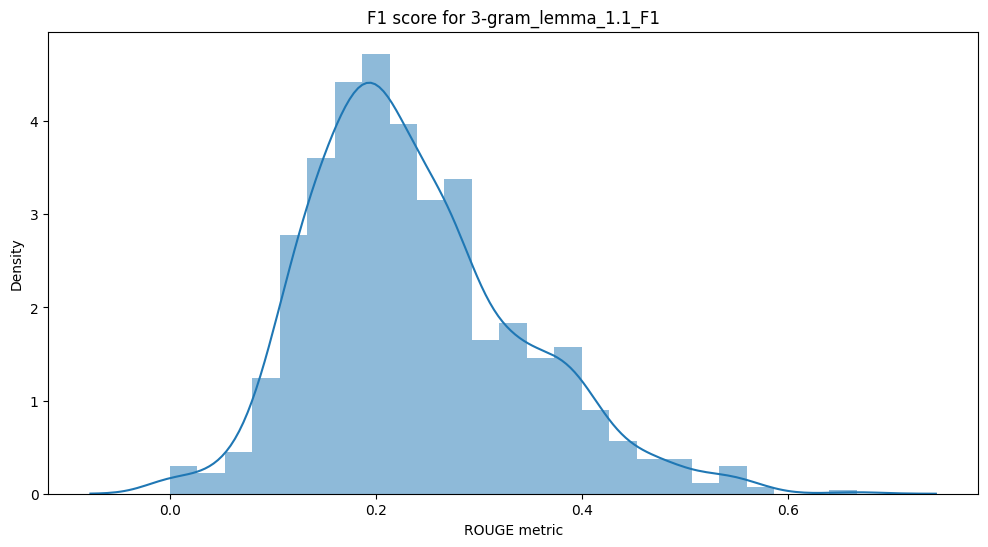

In [21]:
score_column = '3-gram_lemma_1.1_F1'
# print('F1 average = {:.2f}'.format(predictions_scores[score_column].mean()))
# print('F1 max = {:.2f}'.format(predictions_scores[score_column].max()))
# print('F1 standard deviation = {:.2f}'.format(predictions_scores[score_column].std()))


_, ax = plt.subplots(figsize = (12,6))
sns.distplot(predictions_scores[score_column], ax = ax, bins = 25, hist_kws={'alpha':0.5}, label = score_column)
ax.set_xlabel('ROUGE metric')
ax.set_title('F1 score for 3-gram_lemma_1.1_F1')

In [22]:
# print a prettytable of statistics for the rouge scores of summaries 

def score_statistics(df):
  n_grams = list()
  token_types = list()
  thresholds = list()
  metrics = list()

  for column in df.columns:
    params = column.split('_')
    if params[0] not in n_grams:
        n_grams.append(params[0])
    if params[1] not in token_types:
        token_types.append(params[1])
    if params[2] not in thresholds:
        thresholds.append(params[2])
    if params[3] not in metrics:
        metrics.append(params[3])
    
  index =pd.MultiIndex.from_product([n_grams, token_types])
  statistic_names = ['Mean','Standard Deviation']
  columns = pd.MultiIndex.from_product([statistic_names, thresholds])
  scores_statistics_df = pd.DataFrame(index = index, columns = columns)
  
  for score_column in df.columns:
    params = score_column.split('_')
    
    score_mean = round(df[score_column].mean()*100, 2)
    score_std = round(df[score_column].std()*100, 2)
    score_zeros = str(round((df.loc[df[score_column] == 0,score_column].count() / len(df))*100, 2)) +' %'

    scores_statistics_df.loc[(params[0], params[1]), ('Mean', params[2])] = score_mean
    scores_statistics_df.loc[(params[0], params[1]), ('Standard Deviation', params[2])] = score_std
    scores_statistics_df.loc[(params[0], params[1]), ('% of zeros', params[2])] = score_zeros

  return scores_statistics_df

In [23]:
comparision_scores=score_statistics(predictions_scores)


In [24]:
# comparision_scores.to_pickle("./data/corpus/comparisionF1_freq_score.pkl")
# comparision_scores=pd.read_pickle("./data/corpus/comparisionF1_freq_score_1000.pkl")
comparision_scores


Mean                             Standard Deviation         \
                  1    1.1    1.2    1.3    1.4                  1    1.1   
1-gram stem   20.26  22.49  23.51  22.94  20.93               9.05  10.01   
       lemma  20.31  22.46  23.51  22.79  21.02               9.13  10.03   
2-gram stem   20.84  23.13  23.48  21.27  18.64               9.24  10.09   
       lemma  20.83  23.15  23.32  21.41  18.64                9.2  10.03   
3-gram stem   21.39  23.54  22.57  19.97  16.67               9.13  10.12   
       lemma  21.43  23.69  22.54  19.74  16.54               9.14  10.22   

                                  % of zeros                                
                1.2    1.3    1.4          1    1.1    1.2     1.3     1.4  
1-gram stem   10.31  10.91  11.67      0.0 %  0.2 %  1.3 %   5.1 %  10.8 %  
       lemma  10.21  10.85  11.44      0.0 %  0.3 %  1.3 %   4.6 %  10.2 %  
2-gram stem   10.65  11.53  12.26      0.0 %  0.4 %  2.8 %   9.9 %  18.4 %  
       lemma  10.72  11.47  12.08      0.0 %  0.5 %  3.1 %   9.5 %  17.6 %  
3-gram stem    10.8  12.12  12.39      0.0 %  0.6 %  5.1 %  14.4 %  22.8 %  
       lemma  10.88  11.97  12.45      0.0 %  0.8 %  5.6 %  14.0 %  22.7 %

In [76]:
# predictions_scores_10000=pd.read_pickle("./data/corpus/score_compare_10000.pkl")
# predictions_scores_10000
# predictions_scores_10000.max()


##### for predictions = 1000 , F1 Score : 23.69 
##### for predictions = 2000 , F1 Score : 24 



### Difference of number of sentences between hypothesis and reference

In [25]:
def len_sent_tokenize(text):
  return len(sentence_tokenize(text))
qty_of_sentences = predictions_test['1-gram_stem_1.2'].apply(len_sent_tokenize)

In [26]:
qty_of_sentences_reference = predictions_test['reference'].apply(len_sent_tokenize)
diff_number_of_sentences = qty_of_sentences - qty_of_sentences_reference


In [27]:
print(diff_number_of_sentences)
print(np.max(diff_number_of_sentences))
print(np.min(diff_number_of_sentences))


0        10
90        1
181       0
272      -2
363      -1
         ..
90243     8
90333     8
90424     0
90514    -1
90604     5
Length: 1000, dtype: int64
34
-4


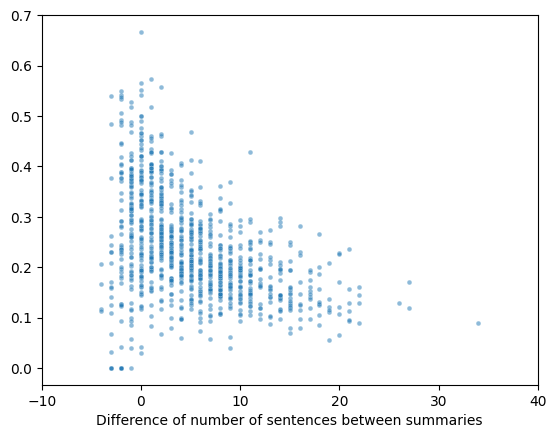

In [28]:
sns.scatterplot(x = diff_number_of_sentences, 
            y = predictions_scores['3-gram_lemma_1.1_F1'].values,
            alpha =0.5, s = 12)

plt.xlabel('Difference of number of sentences between summaries')
plt.xlim((-10,+40))
plt.show()

#### The generated summaries are longer than the reference summary => the higher the difference of length, the lower the ROUGE score.
